**Author:** Regina Hoo

**Institution:** Wellcome Sanger institute

**April, 2023**

---

##  Clustering analysis of the HTO datasets - Donor Hrv133

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import anndata
import scvi

    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/clusters/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable


fig_path= './figures/clusters/'

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
absl                NA
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiw

In [2]:
def doublet_assing(adata_obj, cell_id):
    
    '''
    Function that assigns the "doublet" label to the cells that were pooled
    
    input
        adata_obj: adata object
        cell_id: ID of a sinfle cell

    '''
    
    #is_doublet label of the current cell, it's a boolean value
    curr_isDoublet = adata_obj.obs.loc[cell_id, 'is_doublet']


    #If the is_doublet is True, then the function willl return the "doublet"
    # Otherwise it will return the "singlet". 
    if curr_isDoublet == True:
        return("doublet")
    
    else:
        return("singlet")

    

In [3]:
adata = sc.read('rna1_counts_HTO_adata_new.h5ad')
adata.X.shape

(19607, 36601)

In [4]:
adata.X=adata.layers['raw_counts'].copy()

In [5]:
#Analyse Donor Hrv133

In [6]:
adata = adata[adata.obs['donor'] != 'Hrv132']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Normalization

In [7]:
#Normalize and scale data to run neirest neighbors and plot gene expression
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
#sc.pp.scale(adata, max_value=10)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
sc.pp.neighbors(adata, n_neighbors=20)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [9]:
#clustering
sc.tl.leiden(adata, key_added="leiden", resolution=0.3)

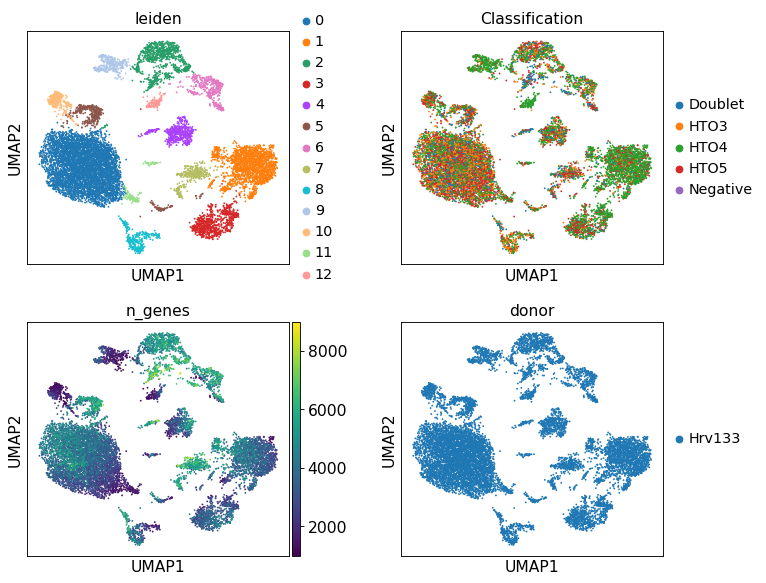

In [10]:
sc.pl.umap(adata, color=["leiden",'Classification', 'n_genes', 'donor' ],
           ncols=2, wspace=0.3)

In [11]:
adata = adata[adata.obs['Classification'] != 'Negative']
adata = adata[adata.obs['Classification'] != 'Doublet']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


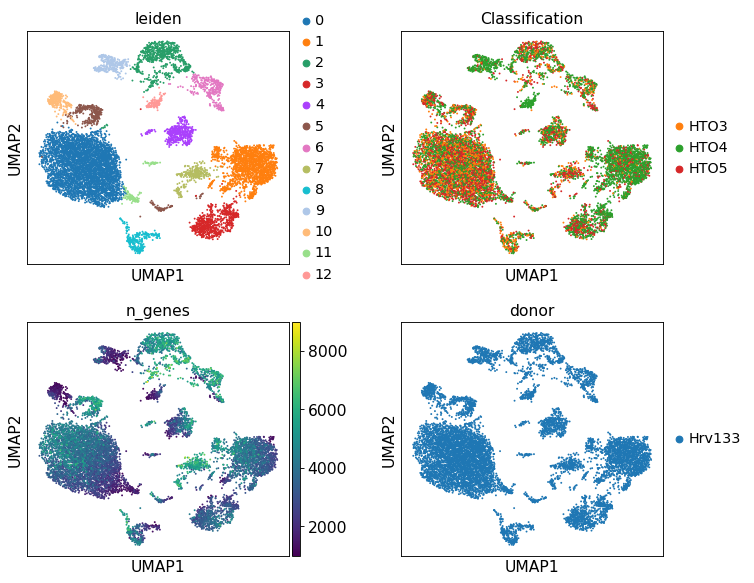

In [12]:
sc.pl.umap(adata, color=["leiden",'Classification', 'n_genes', 'donor' ],
           ncols=2, wspace=0.3)

In [13]:
sc.pp.neighbors(adata, n_neighbors=20)
sc.tl.umap(adata)

In [14]:
#clustering
sc.tl.leiden(adata, key_added="leiden", resolution=0.3)

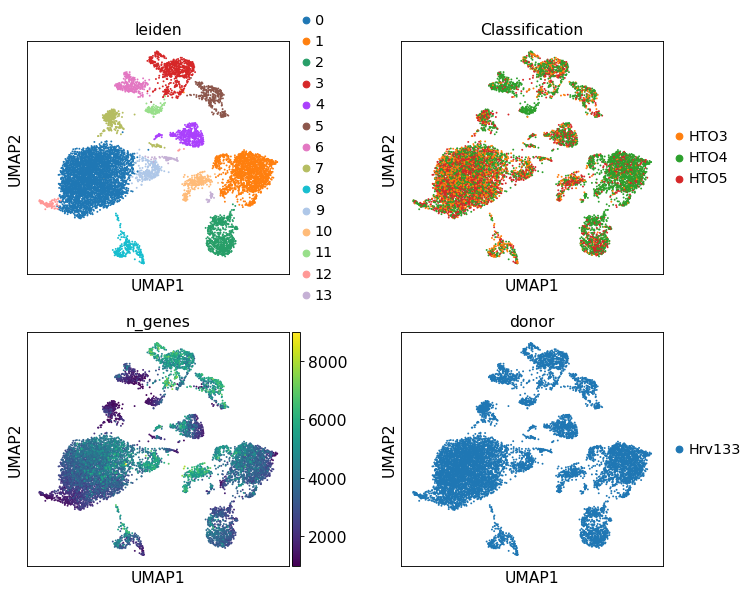

In [15]:
sc.pl.umap(adata, color=["leiden",'Classification', 'n_genes', 'donor' ],
           ncols=2, wspace=0.3)

In [16]:
def Barplot(which_var, adata, var='leiden', height=3, color = False, suffix= ''):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, 
                                 color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/hrv133_barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf',
                       bbox_inches='tight',
                       dpi=300, format= 'pdf', optimize=True)

<ipython-input-16-4927b3686b0e>:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  ax1.figure.savefig(str(sc.settings.figdir)+'/hrv133_barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf',


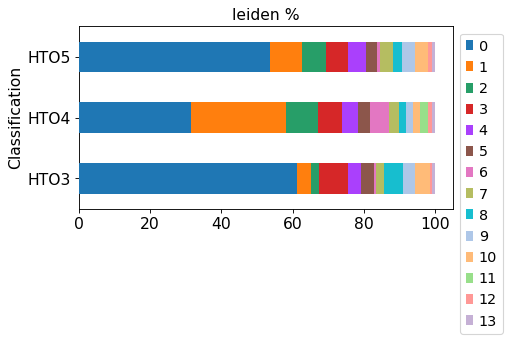

In [17]:
Barplot('leiden', adata, var='Classification')

### Marker genes: plots

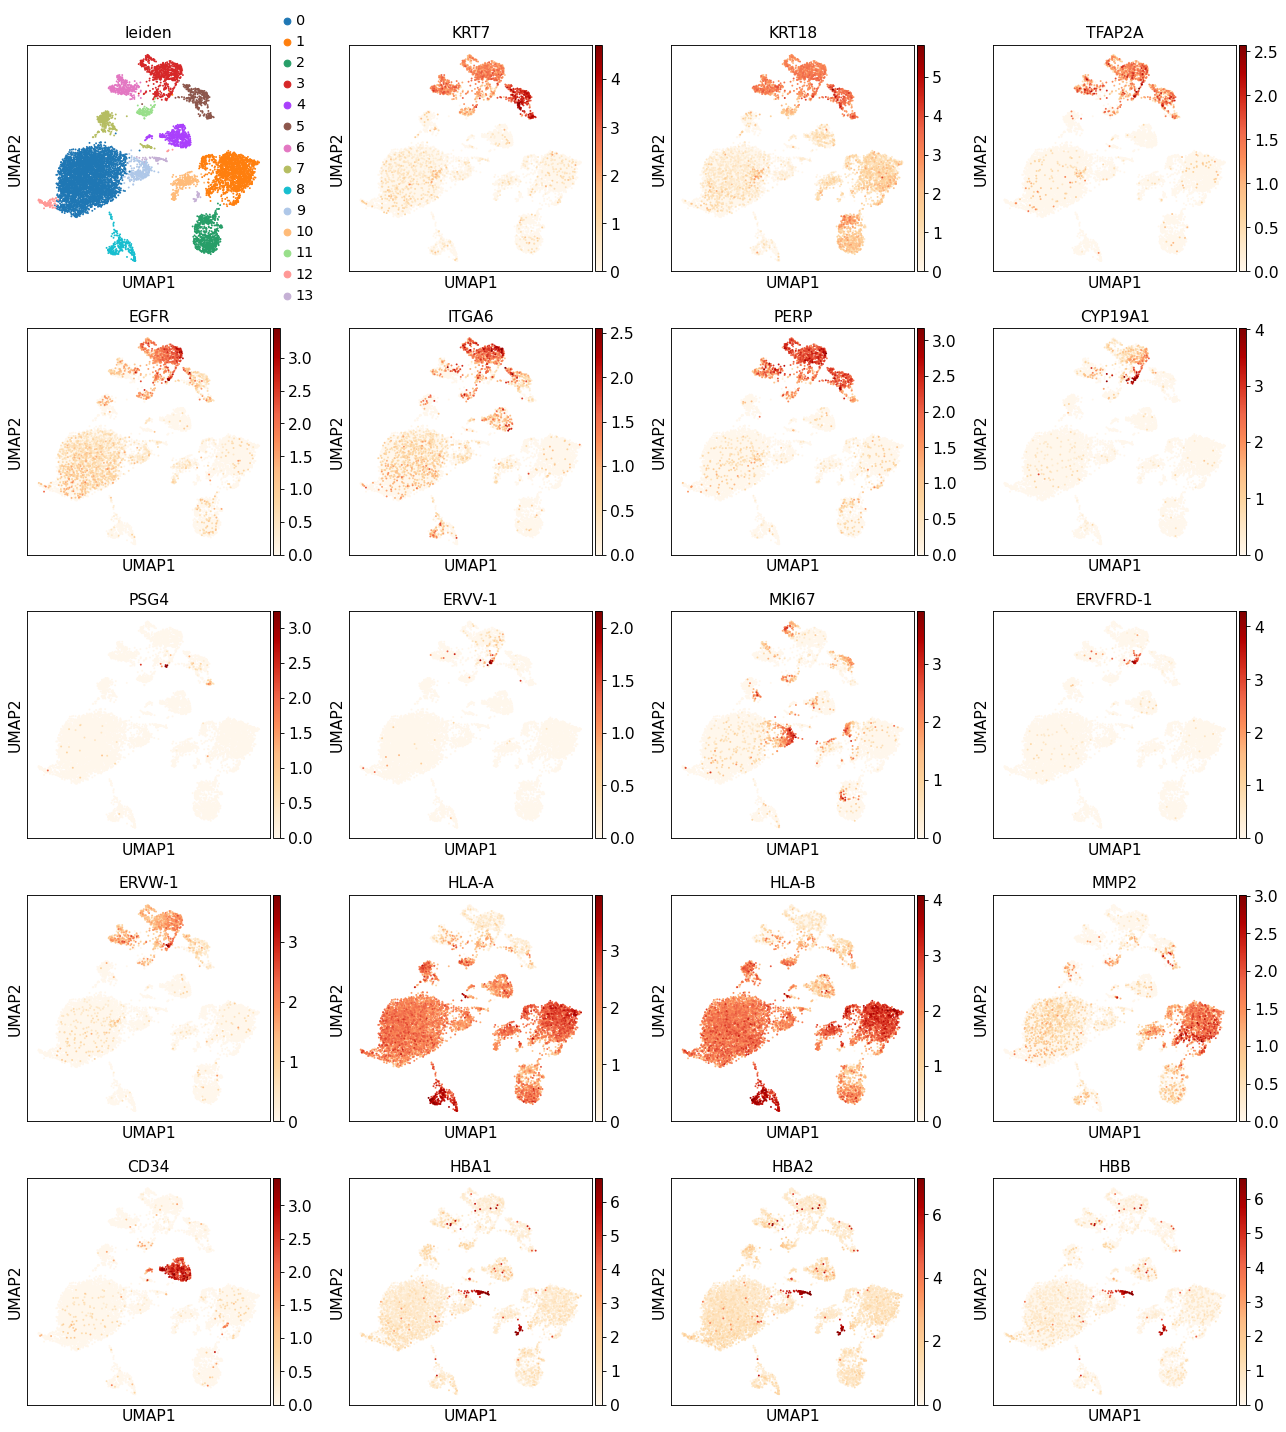

In [18]:
sc.pl.umap(adata, color=['leiden','KRT7','KRT18', 'TFAP2A', 'EGFR' ,'ITGA6','PERP', #Trophoblast
                         'CYP19A1','PSG4', #SCT
                         'ERVV-1', #VCT
                         'MKI67',
                         'ERVFRD-1', 'ERVW-1', #SCT & VCT
                         'HLA-A','HLA-B', # NO trophoblast
                         'MMP2', #dS
                         'CD34', #Endo
                         'HBA1','HBA2','HBB', #Ery
                         ], use_raw=False, color_map='OrRd')

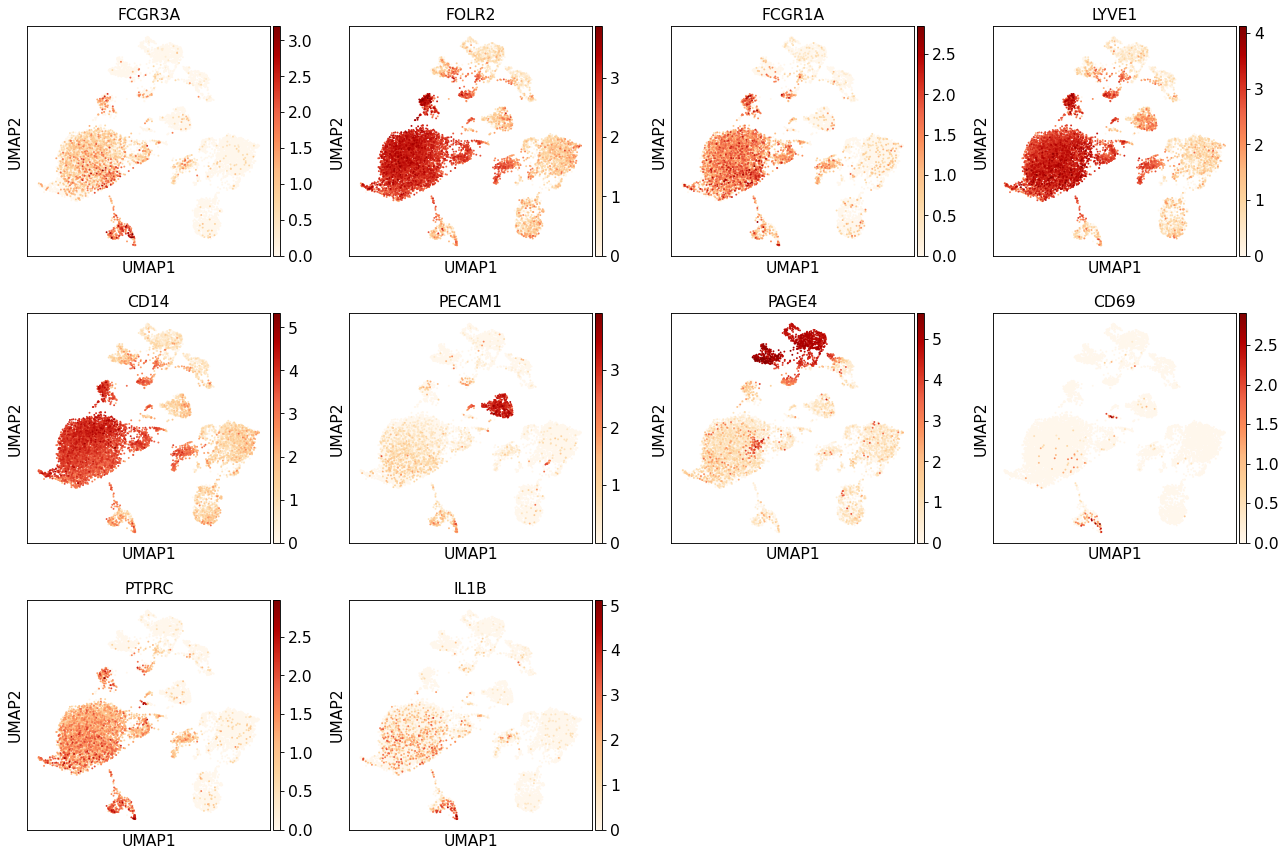

In [19]:
sc.pl.umap(adata, color=['FCGR3A', 'FOLR2', 'FCGR1A', 'LYVE1', 'CD14','PECAM1','PAGE4',
                         'CD69', 'PTPRC','IL1B'],color_map='OrRd',use_raw=False)

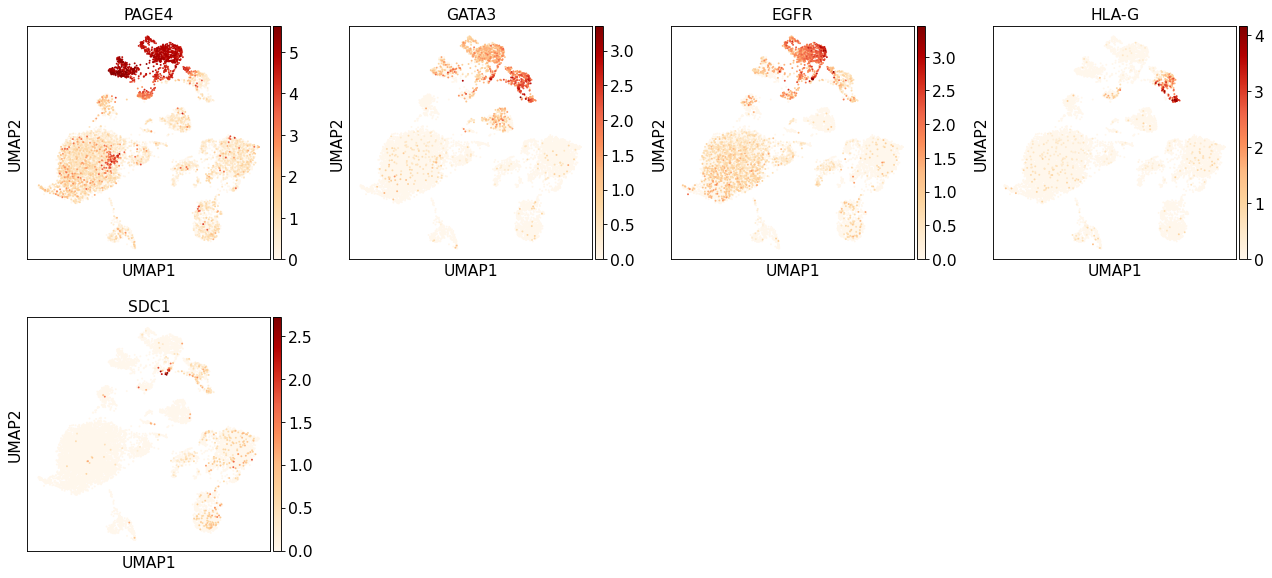

In [20]:
sc.pl.umap(adata, color=['PAGE4', 'GATA3', 'EGFR', 'HLA-G','SDC1'] ,use_raw=False, color_map='OrRd')

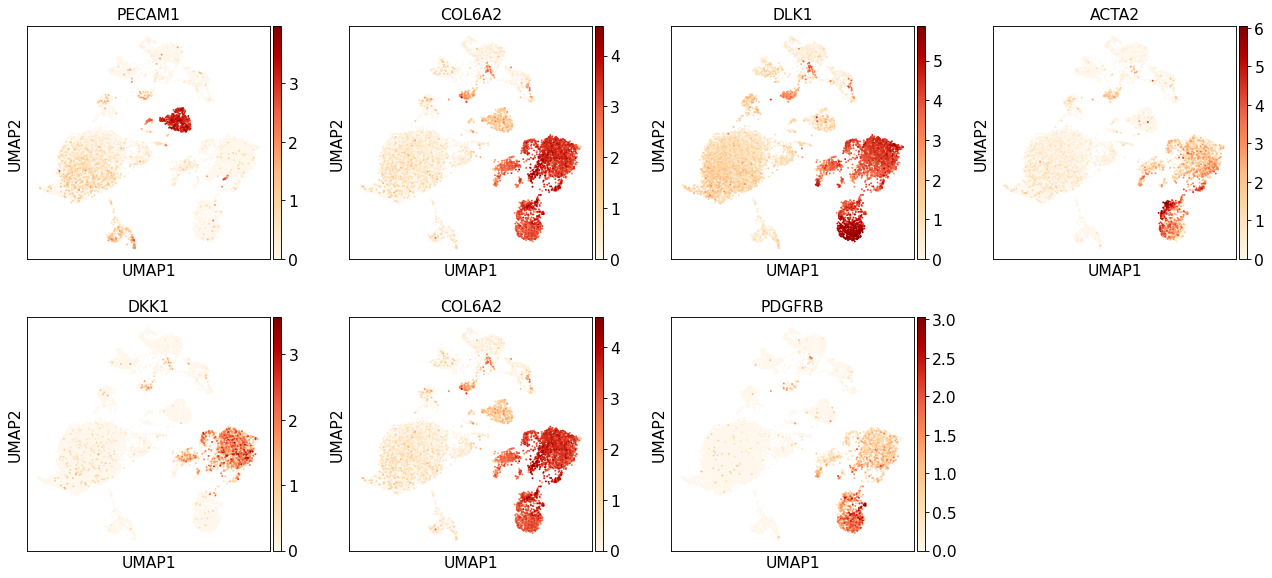

In [21]:
sc.pl.umap(adata, color=['PECAM1', 'COL6A2',
                        'DLK1', 'ACTA2','DKK1', 'COL6A2','PDGFRB'],color_map='OrRd',use_raw=False)

## Save raw counts

In [22]:
# adding the raw counts
adata.X=adata.layers['raw_counts']
#adata.raw = adata.copy
adata.write('rna2_counts_HTO_donorHrv133_cluster_adata.h5ad')

In [23]:
adata.obs.head()

,sample,donor,termination,day,pcw,percent_mito,n_counts,n_genes,batch,HTO3,...,percent_ribo,doublet_scores,predicted_doublets,most_likely_hypothesis,cluster_feature,negative_hypothesis_probability,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,leiden
Pla_HDBR12261977_Pla_HDBR12261979_AAACCCAAGAGTGAAG,Pla_HDBR12261977_Pla_HDBR12261979,Hrv133,surgical,d0,12pcw,0.054988,14694.0,3920,1,229.0,...,0.192664,0.126654,False,1,0,0.019936,0.876708,0.103356,HTO3,2
Pla_HDBR12261977_Pla_HDBR12261979_AAACCCAAGGCACTAG,Pla_HDBR12261977_Pla_HDBR12261979,Hrv133,surgical,d0,12pcw,0.029845,5026.0,1843,1,96.0,...,0.095503,0.043418,False,1,0,0.023528,0.899901,0.076571,HTO5,0
Pla_HDBR12261977_Pla_HDBR12261979_AAACCCAAGTGAGTTA,Pla_HDBR12261977_Pla_HDBR12261979,Hrv133,surgical,d0,12pcw,0.104257,20459.0,4898,1,83.0,...,0.143360,0.460317,True,1,0,0.009920,0.889809,0.100270,HTO5,10
Pla_HDBR12261977_Pla_HDBR12261979_AAACCCACATCGCCTT,Pla_HDBR12261977_Pla_HDBR12261979,Hrv133,surgical,d0,12pcw,0.146134,5755.0,2453,1,85.0,...,0.048132,0.076077,False,1,0,0.002598,0.840337,0.157065,HTO4,1
Pla_HDBR12261977_Pla_HDBR12261979_AAACCCATCACCCTGT,Pla_HDBR12261977_Pla_HDBR12261979,Hrv133,surgical,d0,12pcw,0.062128,31773.0,6163,1,141.0,...,0.143801,0.445205,True,1,0,0.000002,0.950888,0.049111,HTO4,10


In [24]:
adata

AnnData object with n_obs × n_vars = 10145 × 36601
    obs: 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'HTO3', 'HTO4', 'HTO5', 'total_hto_counts', 'fraction_HTO3', 'fraction_HTO4', 'fraction_HTO5', 'percent_ribo', 'doublet_scores', 'predicted_doublets', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'leiden'
    var: 'gene_ids', 'feature_types'
    uns: 'Classification_colors', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'donor_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'raw_counts'
    obsp: 'distances', 'connectivities'